In this project, we'll fit a model with the first 70% portion of our data and forecast the last 30% portion.<br>
The forecasted values will be plotted with the actual values to determine to usefullness of our model.

In [256]:
import warnings
import pandas as pd
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt
import IPython.display as display
import sys
import warnings

if not sys.warnoptions:
    warnings.simplefilter("ignore")

    
dateparse = lambda x: pd.datetime.strptime(x, '%Y-%m-%d')

#read the data into a dataframe
data = pd.read_csv('./clean_data.csv', date_parser=dateparse)


#drop signal col
data = data.drop('signal', axis=1)

#drop rows with missing values
data = data.dropna(axis=0)

data['date'] = data['date'].map(lambda x: pd.to_datetime(str(x), format='%Y-%m-%d'))


#Make a series with the spy_close_price and date values
series = pd.Series(data['spy_close_price'].values, index = data['date'].values)

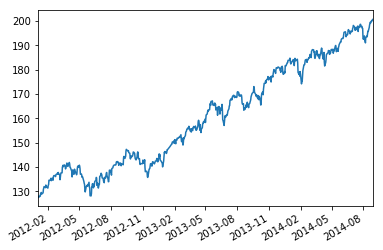

In [257]:
series.plot()
plt.show()

This is a plot of spy_close_price values against their respective dates

The graph above suggests that the data has an upward trend.  Therefore, it is not stationary, meaning that it does not satisfy all of the following:

    1-Constant mean
    2-Constant variance
    3-Autocovariance independent of time

Stationarity is relevent because the model we plan to use, ARIMA, assumes stationarity to make prediction.

In [258]:
from statsmodels.tsa.stattools import adfuller

#Method to determine stationarity
def test_stationarity(timeseries):
    
    #Determing rolling statistics
    rolmean = pd.rolling_mean(timeseries, window=12)
    rolstd = pd.rolling_std(timeseries, window=12)

    #Plot rolling statistics:
    orig = plt.plot(timeseries, color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)
    
    #Perform Dickey-Fuller test:
    print ('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print (dfoutput)

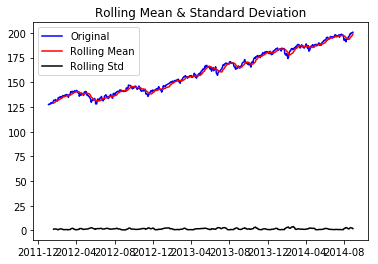

Results of Dickey-Fuller Test:
Test Statistic                  -0.326989
p-value                          0.921594
#Lags Used                       0.000000
Number of Observations Used    664.000000
Critical Value (1%)             -3.440237
Critical Value (5%)             -2.865903
Critical Value (10%)            -2.569093
dtype: float64


In [259]:
test_stationarity(series)

Our data's lack of stationarity is further evidenced above.<br>
The Dickey-Fuller test is used, which indicates p-value way higher than 0.05, thus obvious lack of stationarity.

Fortunately, the ARIMA model is able to make our time series stationary through differencing, taking the difference of our data's observations with previous observations.<br>

We specify the number of nonseasonal differences needed for stationarity in the d parameter of our ARIMA model.

Our ARIMA model takes in at least three parameter (p, d, q)

    -p is the number of autoregressive terms, 
    -d is the number of nonseasonal differences needed for stationarity,  
    -q is the number of lagged forecast errors in the prediction equation. 

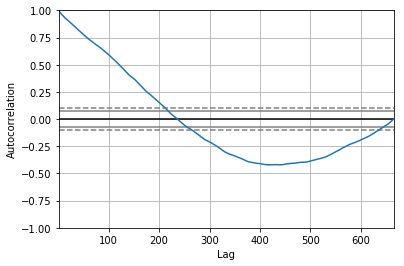

In [260]:
from pandas.tools.plotting import autocorrelation_plot

autocorrelation_plot(series)
plt.show()

The graph above indicates that there is a strong positive correlation for the first 100 lags/autoregressive terms.  However, we'll use 5 as the number of autoregressive terms in our ARIMA model.<br>

Now, we'll test the goodness of an ARIMA model with (5,1,1) parameters below.

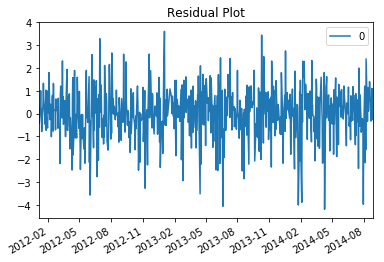

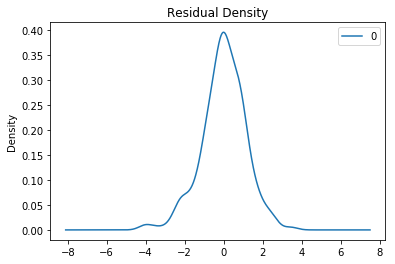

                0
count  664.000000
mean     0.000102
std      1.140057
min     -4.202332
25%     -0.632805
50%      0.019248
75%      0.733491
max      3.608533


In [261]:
from statsmodels.tsa.arima_model import ARIMA
#from matplotlib import pyplot

# fit model
model = ARIMA(series, order=(5,1,1))
model_fit = model.fit(disp=0)
#print(model_fit.summary())

# plot residual errors
residuals = pd.DataFrame(model_fit.resid)
residuals.plot()
plt.title("Residual Plot")
plt.show()

# plot residual errors density
residuals.plot(kind='kde')
plt.title("Residual Density")
plt.show()

print(residuals.describe())

We have tested the goodnes of an ARIMA(5,1,1) model on our entire data.<br><br>
The results above indicate that the distribution of residual erros is centered around zero (0.000102 to be exact).  Thus, there is very little bias in the prediction.

In [262]:
from statsmodels.tsa.arima_model import ARIMA

# series values
X = series.values
#series indices
indices = series.index

size = int(len(X) * 0.70)

#divide series into train and test series
train, test = pd.Series(X[0:size], indices[0:size]), pd.Series(X[size:len(X)], indices[size:len(X)])

history = [x for x in train.values]

#predictions = list()
predictions = pd.Series()

for t in range(len(test)):
    model = ARIMA(history, order=(5,1,1))
    model_fit = model.fit(disp=0)
    output = model_fit.forecast()
    #yhat = output[0]
    yhat = pd.Series(output[0], test.index[[t]])
    predictions = predictions.append(yhat)
    obs = test.values[[t]]
    history.append(obs)
    #print('predicted=%f, expected=%f' % (output[0], obs))

Test MSE: 1.387
r-square 0.967740803416


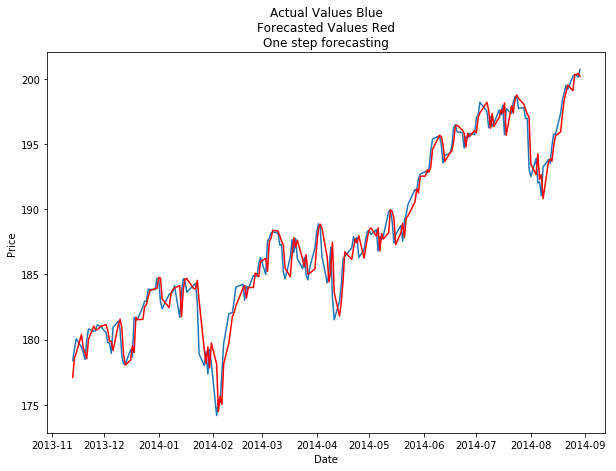

In [263]:
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score


error = mean_squared_error(test.values[:], predictions.values[:])
print('Test MSE: %.3f' % error)

print('r-square', r2_score(test, predictions))

plt.figure(figsize=(10,7))
plt.plot(test)
plt.plot(predictions, color='red')

plt.ylabel('Price')
plt.xlabel('Date')
plt.title('Actual Values Blue\nForecasted Values Red\nOne step forecasting')
plt.show()


Above, we are using <b>one step forecasting</b> using our ARIMA models for <b>each forecasted value</b>.<br><br>
We have forecasted the last 30% portion of our series, all using one step forecasting.  We've done it in the following way.  Once we're done forecasting an observation, we add the actual observation to the training data and recalculate the ARIMA model to forecast the next observation.<br><br>
Then, we have plotted the actual observations<b>(blue)</b> and the forecasted observations<b>(red)</b>.<br>
The MSE and R-Squared values indicate that the ARIMA model is really good at one step forecasting.

In [264]:
# create a differenced series
def difference(dataset, interval=1):
    diff = list()
    for i in range(interval, len(dataset)):
        value = dataset[i] - dataset[i - interval]
        diff.append(value)
    return np.array(diff)
 
# invert differenced value
def inverse_difference(history, yhat, interval=1):
    return yhat + history[-interval]

#series values
X = series.values

#series indices
indices = series.index

size = int(len(X) * 0.70)

remaining = len(X) - size;

#divide series into train and test series
train, test = pd.Series(X[0:size], indices[0:size]), pd.Series(X[size:len(X)], indices[size:len(X)])

X = train.values

#interval
interval = 30
differenced = difference(train.values, interval)
#differenced = differenced[interval:-interval]
# fit model
model = ARIMA(differenced, order=(5,0,1))
model_fit = model.fit(disp=0)
# multi-step out-of-sample forecast
forecast = model_fit.forecast(steps=remaining)[0]
# invert the differenced forecast to something usable
history = [x for x in train.values]
#history = list()
day = 1
for yhat in forecast:
    #print(yhat)
    inverted = inverse_difference(history, yhat, interval)
    #print('Day %d: %f' % (day, inverted))
    history.append(inverted)
    day += 1
#print(history)

r-square 0.718592776031
Test MSE: 12.102


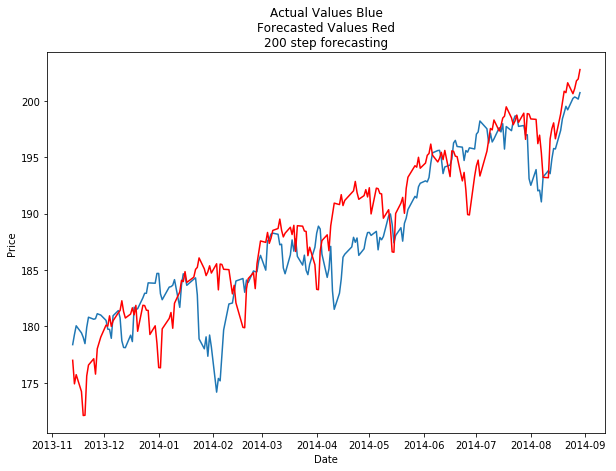

In [265]:
print('r-square', r2_score(test, history[size:]))

error = mean_squared_error(test, history[size:])
print('Test MSE: %.3f' % error)

hist_series = pd.Series(history[size:], test.index)

#print(len(history[size:]), test.shape)
# plot
plt.figure(figsize=(10,7))
plt.plot(test)
plt.plot(hist_series, color='red')

plt.ylabel('Price')
plt.xlabel('Date')

plt.title('Actual Values Blue\nForecasted Values Red\n200 step forecasting')

plt.show()

Above we have used our model to forecast the last 30% observations of our series.  Unlike the previous model, we did not do one step forecasting for each forecast.  Rather we did <b>step=200 or (0.3*len(series))</b> forecasting.<br><br>
The results confirm that it's more difficult to forecast hundreds of values into the future.  Although the model did a good job capturing the trend, it could not accurately account for seasonality, residuals and sudden fluctuations.<br><br>
<b>NB: For the above model, we differenced the data prior to fitting the model.  This was done to speed it up.  Furthermore, the differencing was done with a 30-values interval for more accuracy.  Our logic is equivalent to an ARIMA(5,30,1) model.</b> 

In [266]:
from statsmodels.tsa.arima_model import ARIMA

#series values
X = series.values

#series indices
indices = series.index

size = int(len(X) * 0.70)

#divide series into train and test series
train, test = pd.Series(X[0:size], indices[0:size]), pd.Series(X[size:len(X)], indices[size:len(X)])

history = [x for x in train.values]

#predictions = list()
predictions = pd.Series()

model = ARIMA(history, order=(5,1,0))
model_fit = model.fit(disp=0)
output = model_fit.forecast(steps=len(test))
#yhat = output[0]
yhat = pd.Series(output[0], test.index)
predictions = predictions.append(yhat)
#obs = test.values[[t]]
#history.append(obs)
#print('predicted=%f, expected=%f' % (output[0], obs))

r-square 0.844040897195
Test MSE: 6.707


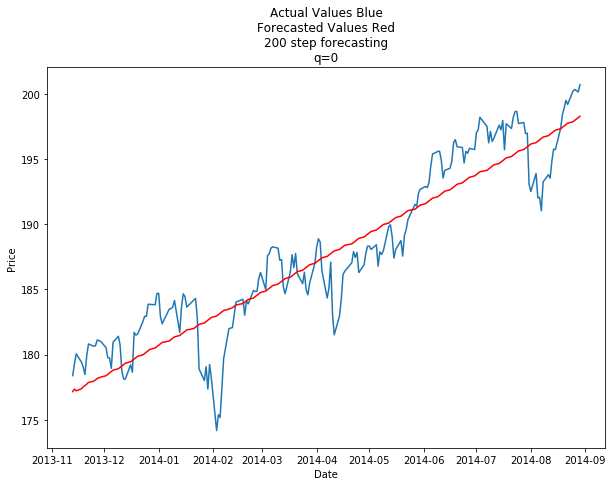

In [267]:
print('r-square', r2_score(test, predictions))

error = mean_squared_error(test, predictions)
print('Test MSE: %.3f' % error)

# plot
plt.figure(figsize=(10,7))
plt.plot(test)
plt.plot(predictions, color='red')

plt.ylabel('Price')
plt.xlabel('Date')

plt.title('Actual Values Blue\nForecasted Values Red\n200 step forecasting\nq=0')

plt.show()

The above is an ARIMA(5,1,0) model.  In this example, q, the number of lagged forecast errors in the prediction equation, is set to zero.<br><br>

This model is just like the previous one, except that q is set to zero.  As a result, our forecasting doesn't attempt to replicate seasonality and fluctuations based on the training data.  I did this because although ARIMA forecasts trends well, I don't believe ARIMA does a good job forecasting seasonality and fluctuations.<br><br>

My idea is to combine the ARIMA model with another seasonality/fluctuation forecasting model.<br><br>
Using the red line as a divider, we can see that there are periods(A) when observed values float well above forecasted values and periods(B) when observed values float well below forecasted values.  In such periods, barring minor fluctuations, the overall trend is to keep going up (period A) or down (period B)<br><br>

After computing statistics regarding the prevalence of periods A and B in the training data, analyzing their patterns/sequences of succession and combining them with seasonality and residuals info calculated below, one should be able to develop a better seasonality/fluctuation model.<br>
I did not develop one, although I did have an unsuccessful attempt.

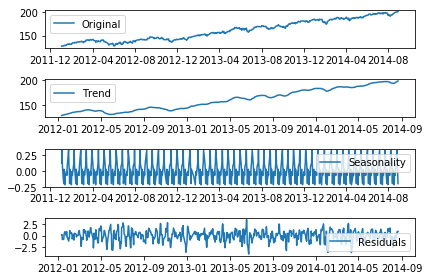

In [268]:
from statsmodels.tsa.seasonal import seasonal_decompose

X = pd.Series(series.values, series.index)

size = int((X.size) * 0.70)

train, test = X[0:size], X[size:len(X)]

history = [x for x in train]


decomposition = seasonal_decompose(X.values, freq=12)

trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid


'''decomposition = seasonal_decompose(test, freq=12)

trend_test = decomposition.trend
seasonal_test = decomposition.seasonal
residual_test = decomposition.resid
'''

plt.subplot(411)
plt.plot(X, label='Original')
#train.plot()
plt.legend(loc='best')
plt.subplot(412)
plt.plot(X.index, trend, label='Trend')
#trend.plot()
plt.legend(loc='best')
plt.subplot(413)
plt.plot(X.index, seasonal, label='Seasonality')
#seasonal.plot()
plt.legend(loc='best')
plt.subplot(414)
plt.plot(X.index, residual, label='Residuals')
#residual.plot()
plt.legend(loc='best')
plt.tight_layout()

plt.show()